# Decision making under uncertainty

In this lecture, you learned about how the Markov decision process (MDP) framework can be extended to allow uncertainty about the states. This can be used to model a wide range of decision-making problems where there is uncertainty or noise associated with the state of the world.

We considered the example of the random dot motion discrimination task, where a subject must indicate the direction in which the majority of dots are moving. In this assignment, you will solve a two-stage formulation of this task, where the decision-maker can either make an immediate decision (i.e., at the first stage) on the basis of initial information, or choose to wait and gather further information before making their choice (i.e., at the second stage). The complete description of the problem can be found in the lecture slides and also in the original paper: http://www.gatsby.ucl.ac.uk/~dayan/papers/NDM002wc.pdf

Your task is to reproduce the plots from Figure 9 of the paper, interpret the results, and explain the steps of the solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## 0. Define the parameters of the model (0.5 pts)

In [2]:
# INSERT CODE HERE
u1 = 4
u2 = 6
stdev = 1
pr_1 = 0.5
pr_2 = 0.5
punishment = -0.1

## 1. Updating the belief state  (2.5 pts)
The actual direction of motion ('state') is not completely observable to the subject. Hence, the subject can only rely on observations to compute the *belief* that the direction of motion is left or right (this is the posterior probability or 'belief state'). 

### 1a. Write a function that will calculate this posterior given the prior belief and an observation (the belief update). (0.5 pt)

In [3]:
# INSERT CODE BELOW

def belief_state(prior1, prior2, observation):
    l_ca = norm.pdf(observation, u1, stdev)/norm.pdf(observation,u2,stdev)
    bs = 1/(1+(1/l_ca)*(prior1/prior2))

    return bs


### 1b. Use this function to update the belief on the first observation at step $\beta$ and reproduce Fig 9A.  Interpret the plot. (1 pt)

In [4]:
# INSERT CODE BELOW

#Pick a random state
start = np.random.choice(u1,u2)
obs_1 = np.arange(0,10,0.5)
b_states_1 = np.zeros(len(obs_1))
b_states_2 = np.zeros(len(obs_1))
for indices, obs in enumerate(obs_1):
    b_states_1[indices] = belief_state(pr_1,pr_2,obs)
b_states_2 = 1 - b_states_1



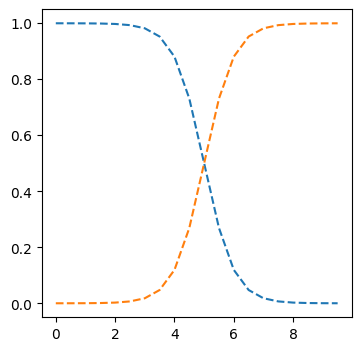

In [5]:
plt.figure(figsize=(4,4))
plt.plot(obs_1,b_states_1,linestyle='--')
plt.plot(obs_1,b_states_2,linestyle='--')

INSERT ANSWER BELOW

At small observations, the belief state x1 is larger than that of x2, and vice versa for large observations. This is a simple consequence of P(c|x1) outweighing P(c|x2) (i.e. 1/l_c1 is small) at smaller observations, and decreases as the observation magnitude increases. 

### 1c. Write a function to update the belief on observing another sample at step $\alpha$ and reproduce Fig 9B.  Interpret the plot. (1 pt)
Hint: You will have to calculate this probability for every possible pair of observations.

In [6]:
#INSERT CODE BELOW
obs_2 = np.copy(obs_1)
two_obs_belief_1 = np.zeros((len(obs_1),len(obs_2)))
two_obs_belief_2 = np.zeros((len(obs_1),len(obs_2)))
for i, obs in enumerate(obs_2):
    two_obs_belief_1[i,:] = norm.pdf(obs,u1,stdev) * b_states_1
    two_obs_belief_2[i,:] = norm.pdf(obs,u2,stdev) * b_states_2
    two_obs_belief_1[i,:] = two_obs_belief_1[i,:] / (two_obs_belief_2[i,:]+two_obs_belief_1[i,:])
    two_obs_belief_2[i,:] = 1 - two_obs_belief_1[i,:]






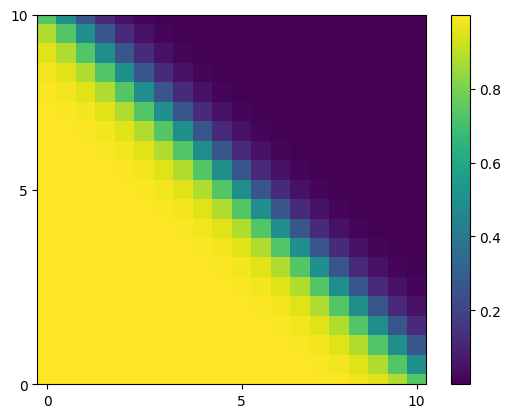

In [7]:
plt.imshow(two_obs_belief_1)
plt.xticks(ticks=(0,10,19),labels=(0,5,10))
plt.ylim(0,19)
plt.yticks(ticks=(0,10,19),labels=(0,5,10))
plt.colorbar()

INSERT ANSWER BELOW

The belief state depends on the mean of the observations. On the diagonal are observations with mean 5, which is has the same difference from the means of the two states and therefore is the most uncertain. The further away from the diaognals the more the mean diverges away from 5, leading to more certain belif states.

## 2. Solving for the optimal actions (7 pts)
Now that we have a way to update the belief states, we can use them to determine the best course of action at each of the steps (the 'optimal policy'). 

### 2a. When finding the optimal policy, why does it make sense to calculate the best action at the final stage $\alpha$, and work backwards? (1 pt)

INSERT ANSWER BELOW

This is because the initial choice values depend on the choice values in the later step. Hence, working out the best action in the later stage informs the earlier stage. 

### 2b. Write a function that will calculate the value of the best action at $\alpha$ and reproduce Fig 9C. Explain what the plot shows. (1 pt)

In [8]:
# INSERT CODE BELOW
#Value = max probability out given both obs 
def alpha_action_value(bf_1, bf_2):
    val = np.max([bf_1,bf_2])
    return val



In [9]:
values_alpha = np.zeros(np.shape(two_obs_belief_1))
for indices, obs in enumerate(obs_1):
    for indices2, obs2 in enumerate(obs_2):
        values_alpha[indices,indices2] = alpha_action_value(two_obs_belief_1[indices,indices2],two_obs_belief_2[indices,indices2])

([<matplotlib.axis.YTick at 0x1a941ef92e0>,
 [Text(0, 0, '0'), Text(0, 10, '5'), Text(0, 19, '10')])

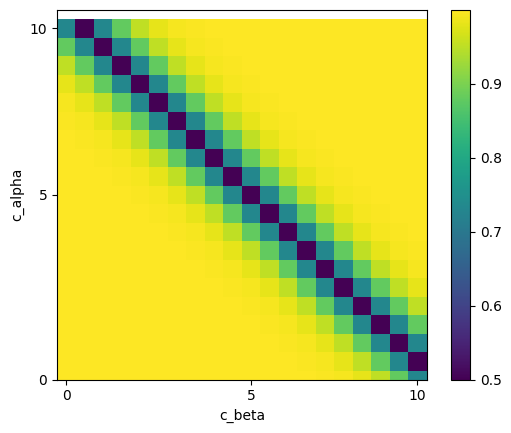

In [12]:
#Plot 
plt.imshow(values_alpha)
plt.ylim(0,20)
plt.colorbar()
plt.ylabel("c_alpha")
plt.xlabel("c_beta")
plt.xticks(ticks=(0,10,19),labels=(0,5,10))
plt.yticks(ticks=(0,10,19),labels=(0,5,10))



INSERT ANSWER BELOW

The value is defined as the maximum of the probabilities that the agent occupies each state. The closer to the diagonal (including the diagonal), the smaller the maximal probabilities, which directly correlates to smaller values.

### 2c. Before finding the best action at $\beta$, we have one more step to do. We need the values of the best actions at $\alpha$ that we just calculated and the probability of observing $c_{\alpha}$ given $c_{\beta}$ ($P(c_{\alpha} | c_{\beta})$). Why? (1 pt)

INSERT ANSWER BELOW

The value of action at beta depends on the value of the action at alpha, which itself depends on the observation, therefore both is required. More explicitly, we need to consider all probabilities and their corresponding action value. 

### 2d. Write a function that will calculate $P(c_{\alpha} | c_{\beta})$ and reproduce Fig 9D. Explain how you calculated this probability and what the plot shows. (1 pt)
Hint: You will have to marginalise the posteriors over the possible states.

In [13]:
# INSERT CODE BELOW
def prob_ca_cb(belief_state_1,belief_state_2,obs):
    from_state_1 = belief_state_1 * norm.pdf(obs,u1,stdev)
    from_state_2 = belief_state_2 * norm.pdf(obs,u2,stdev)
    pcacb = from_state_1 + from_state_2
    return pcacb


In [14]:
pcacb = np.zeros(np.shape(values_alpha))
for indices, obs in enumerate(obs_1):
    for indices2, obs2 in enumerate(obs_2):
        pcacb[indices2,indices] = prob_ca_cb(b_states_1[indices],b_states_2[indices],obs_1[indices2])

Text(0, 0.5, 'p_cb')

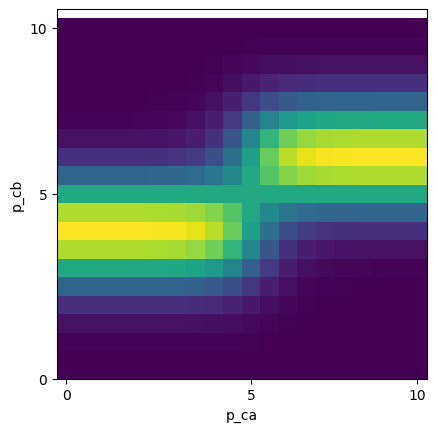

In [17]:
plt.imshow(pcacb)
plt.ylim(0,20)
plt.xticks(ticks=(0,10,19),labels=(0,5,10))
plt.yticks(ticks=(0,10,19),labels=(0,5,10))
plt.xlabel("p_ca")
plt.ylabel("p_cb")


INSERT ANSWER BELOW

This probability is basically equivalent to the probability given some observation c_beta, which state (distribution) it belongs to i.e. the belief state, and from these states how likely is c_alpha observed. 

### 2e. We are now ready to find the best action at $\beta$. Write a function that calculates the values associated with each of the actions and reproduce Fig 9E. What does the plot tell you about what the best action is at $\beta$? (1 pt)
Hint: For action C, you will have to numerically integrate over possible observations ${c_{\alpha}}$ using the step size ($dc_{\alpha}$) you defined on your Gaussian observation distribution. 

In [18]:
# INSERT CODE BELOW
'''def find_int(alpha_values, c_alpha): #Trapezoidal rule
    if not isinstance(alpha_values, np.ndarray):
        raise TypeError("Not an np.ndarray")
    if not isinstance(c_alpha, np.ndarray):
        raise TypeError("Not an np.ndarray")
    func = alpha_values * norm.pdf(c_alpha,u1,stdev)
    integral1 = 0.5 * (func[0] + func[-1]) 
    for i in range(len(alpha_values)):
        integral1 += alpha_values[i]
    integral1 *= 0.5
    func2 = alpha_values * norm.pdf(c_alpha,u2,stdev)
    integral2 = 0.5 * (func2[0] + func2[-1]) 
    for i in range(len(alpha_values)):
        integral2 += alpha_values[i]
    integral2 *= 0.5
    return integral1, integral2'''

def action_values_beta(punishment, belief1, belief2,alpha_values,c_alpha):
    q_left = belief1
    q_right = belief2
    V = np.zeros(len(obs_1))
    for indices in range(len(obs_1)):
        for indices2 in range(len(c_alpha)):
            V[indices] += 0.5 * values_alpha[indices,indices2] * ( belief1[indices] * norm.pdf(c_alpha[indices2],u1,stdev) + belief2[indices] * norm.pdf(c_alpha[indices2],u2,stdev) )
                                                                  
    q_c = punishment + V
    return q_left, q_right, q_c

In [19]:
q_c = np.zeros(len(obs_1))
q_left, q_right, q_c = action_values_beta(punishment,b_states_1, b_states_2, values_alpha, obs_1 )
best_immediate_q = np.zeros(np.shape(q_left))
for indices in range(len(best_immediate_q)):
    best_immediate_q[indices] = np.max([q_left[indices],q_right[indices]])
diff = q_c - best_immediate_q 
equal_p = np.where(diff>0)

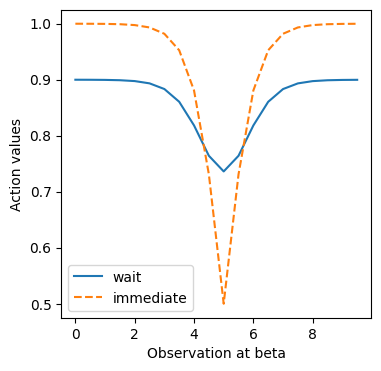

In [22]:
plt.figure(figsize=(4,4))
plt.plot(obs_1,q_c, label="wait")
plt.plot(obs_1,best_immediate_q,"--", label="immediate")
plt.xlabel("Observation at beta")
plt.ylabel("Action values")
plt.legend()

INSERT ANSWER BELOW

When q_c is larger than the best of either q_left or q_right (q_immediate), it is better to wait for one more observation

### 2f. What will reduce (or increase) the range of observations at $\beta$ where it is best to choose to wait for another observation (choosing C)? Can you tweak a parameter to do this and produce a plot similar to Fig 9E to show this? (2 pts)
Hint: You will have to re-run the steps with this changed parameter. 

In [23]:
# INSERT CODE BELOW
q_c = np.zeros(len(obs_1))
q_left, q_right, q_c = action_values_beta(-0.2,b_states_1, b_states_2, values_alpha, obs_1 )
best_immediate_q = np.zeros(np.shape(q_left))
for indices in range(len(best_immediate_q)):
    best_immediate_q[indices] = np.max([q_left[indices],q_right[indices]])
diff = q_c - best_immediate_q 
equal_p = np.where(diff>0)

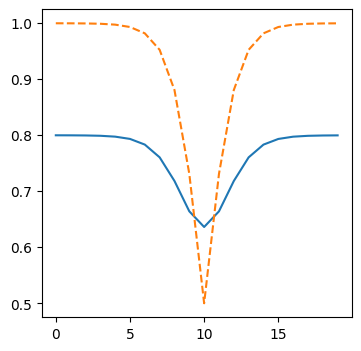

In [24]:
plt.figure(figsize=(4,4))
plt.plot(q_c)
plt.plot(best_immediate_q,"--")


INSERT ANSWER BELOW

Increasing the punishment will decrease the range of observations to wait. The plot is basically shifted downwards. The distributions themselves (mean, standard deviation) will affect the range of observations where it is best to wait. By increasing the standard deviation, the overlap between the distributions increase and therefore options become less clear, increasing the range of observations to wait.